In [36]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, train_test_split, learning_curve
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, f1_score, accuracy_score, make_scorer, ConfusionMatrixDisplay, precision_score, recall_score, mean_absolute_error, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier


Cargo el Dataset modificado anteriormente para usarlo en los modelos

In [13]:
url = 'Dataframe.csv'
df = pd.read_csv(url, sep = ',')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,posibilidad_stroke
0,9046,1,67,0,1,1,1,228,36,1,0,0,1,0,0,0,1,0,0,1
1,51676,0,61,0,0,1,0,202,30,1,0,0,0,1,0,0,0,1,0,1
2,31112,1,80,0,1,1,0,105,32,1,0,0,1,0,0,0,0,1,0,1
3,60182,0,49,0,0,1,1,171,34,1,0,0,1,0,0,0,0,0,1,1
4,1665,0,79,1,0,1,0,174,24,1,0,0,0,1,0,0,0,1,0,1


Teniendo en cuenta todos los Insight realizados e investigaciones sobre los ACV voy a generar etiquetas relacionando variables del DF

Primero una etiqueta que relacione la Edad, Glucosa en Sangre, BMI y el tipo de Trabajo.
Esto porque el estres de distintas situaciones de trabajo genera distintos niveles de BMI y glucosa en sangre.
La edad se usa como linea de tiempo mientras mas grande mas tiempo de trabajo.

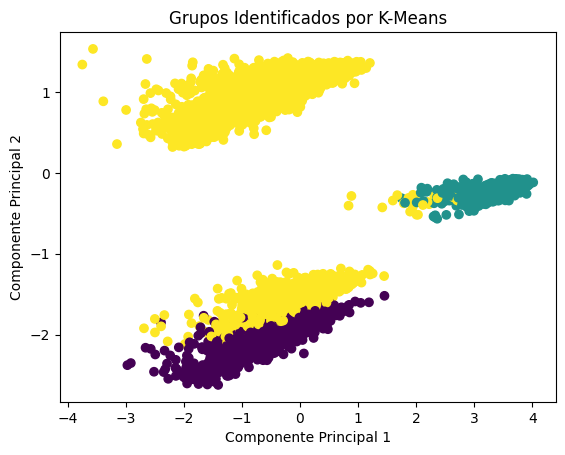

In [14]:
# Seleccionar las características para el análisis de clustering
X = df[['age', 'avg_glucose_level', 'bmi', 'work_type_Govt_job', 'work_type_Never_worked', 'work_type_Private', 'work_type_Self-employed', 'work_type_children']]

# Estandarizar las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicar K-Means para encontrar clusters
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=32)
clusters = kmeans.fit_predict(X_scaled)

# Agregar la columna de clusters al DataFrame original
df['work_salud'] = clusters

# Aplicar PCA para reducir la dimensionalidad a 2 componentes
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Visualizar los grupos en un scatterplot
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis')
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.title("Grupos Identificados por K-Means")
plt.show()


Segundo una relacion entre la Edad, Glucosa en Sangre, BMI y el tipo de Fumador.
Esto porque el tipo de fumador genera distintos niveles de BMI y glucosa en sangre.
La edad se usa como linea de tiempo mientras mas grande mas se ven los efectos del tabaquismo.

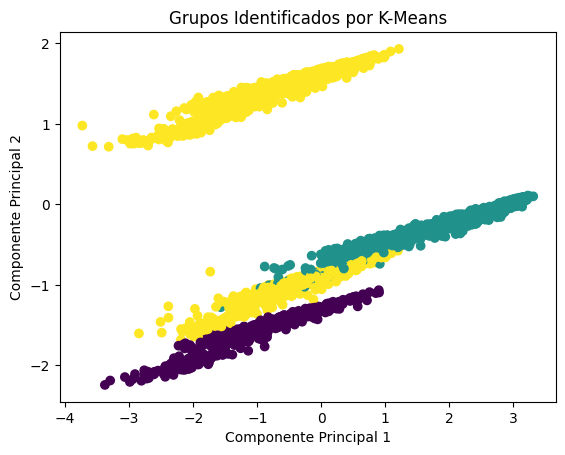

In [15]:
#Seleccionar las características para el análisis de clustering
X = df[['age', 'avg_glucose_level', 'bmi', 'smoking_status_Unknown', 'smoking_status_formerly smoked', 'smoking_status_never smoked', 'smoking_status_smokes']]

# Estandarizar las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicar K-Means para encontrar clusters
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=78)
clusters = kmeans.fit_predict(X_scaled)

# Agregar la columna de clusters al DataFrame original
df['smoking_salud'] = clusters

# Aplicar PCA para reducir la dimensionalidad a 2 componentes
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Visualizar los grupos en un scatterplot
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis')
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.title("Grupos Identificados por K-Means")
plt.show()


Los ultimos 2 clusters los separo entre BMI y Glucosa en Sangre ya que asi se consigue una mejor distribucion de las variables, sino se genera un clsuter sin forma.

El tercero la relacion entre Hipertension, DCV y BMI.

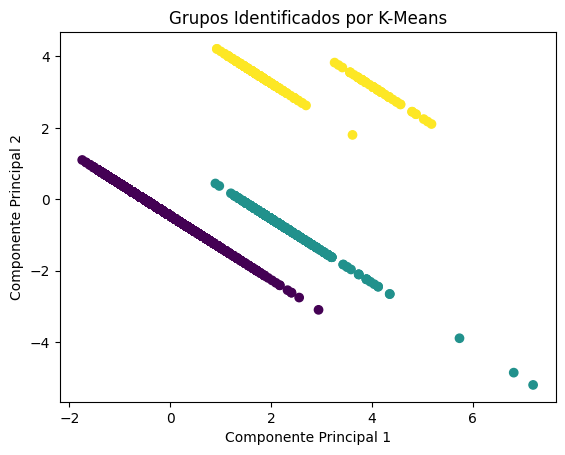

In [16]:
#Seleccionar las características para el análisis de clustering
X = df[['hypertension', 'heart_disease', 'bmi']]

# Estandarizar las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicar K-Means para encontrar clusters
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=32)
clusters = kmeans.fit_predict(X_scaled)

# Agregar la columna de clusters al DataFrame original
df['bmi_hdcv'] = clusters

# Aplicar PCA para reducir la dimensionalidad a 2 componentes
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Visualizar los grupos en un scatterplot
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis')
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.title("Grupos Identificados por K-Means")
plt.show()


El cuarto la relacion entre Hipertension, DCV y Glucosa en sangre.

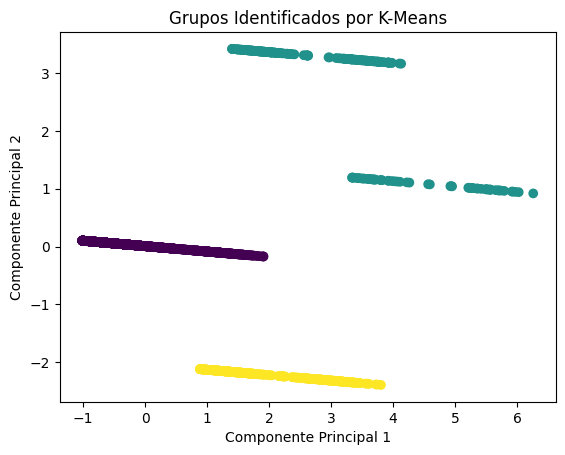

In [17]:
#Seleccionar las características para el análisis de clustering
X = df[['hypertension', 'heart_disease', 'avg_glucose_level']]

# Estandarizar las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicar K-Means para encontrar clusters
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=32)
clusters = kmeans.fit_predict(X_scaled)

# Agregar la columna de clusters al DataFrame original
df['avg_hdcv'] = clusters

# Aplicar PCA para reducir la dimensionalidad a 2 componentes
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Visualizar los grupos en un scatterplot
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis')
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.title("Grupos Identificados por K-Means")
plt.show()


In [18]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,...,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,posibilidad_stroke,work_salud,smoking_salud,bmi_hdcv,avg_hdcv
0,9046,1,67,0,1,1,1,228,36,1,...,0,0,1,0,0,1,2,0,2,1
1,51676,0,61,0,0,1,0,202,30,1,...,0,0,0,1,0,1,0,2,0,0
2,31112,1,80,0,1,1,0,105,32,1,...,0,0,0,1,0,1,2,2,2,1
3,60182,0,49,0,0,1,1,171,34,1,...,0,0,0,0,1,1,2,2,0,0
4,1665,0,79,1,0,1,0,174,24,1,...,0,0,0,1,0,1,0,2,1,2


Genero mapa de correlatividad entre variables.

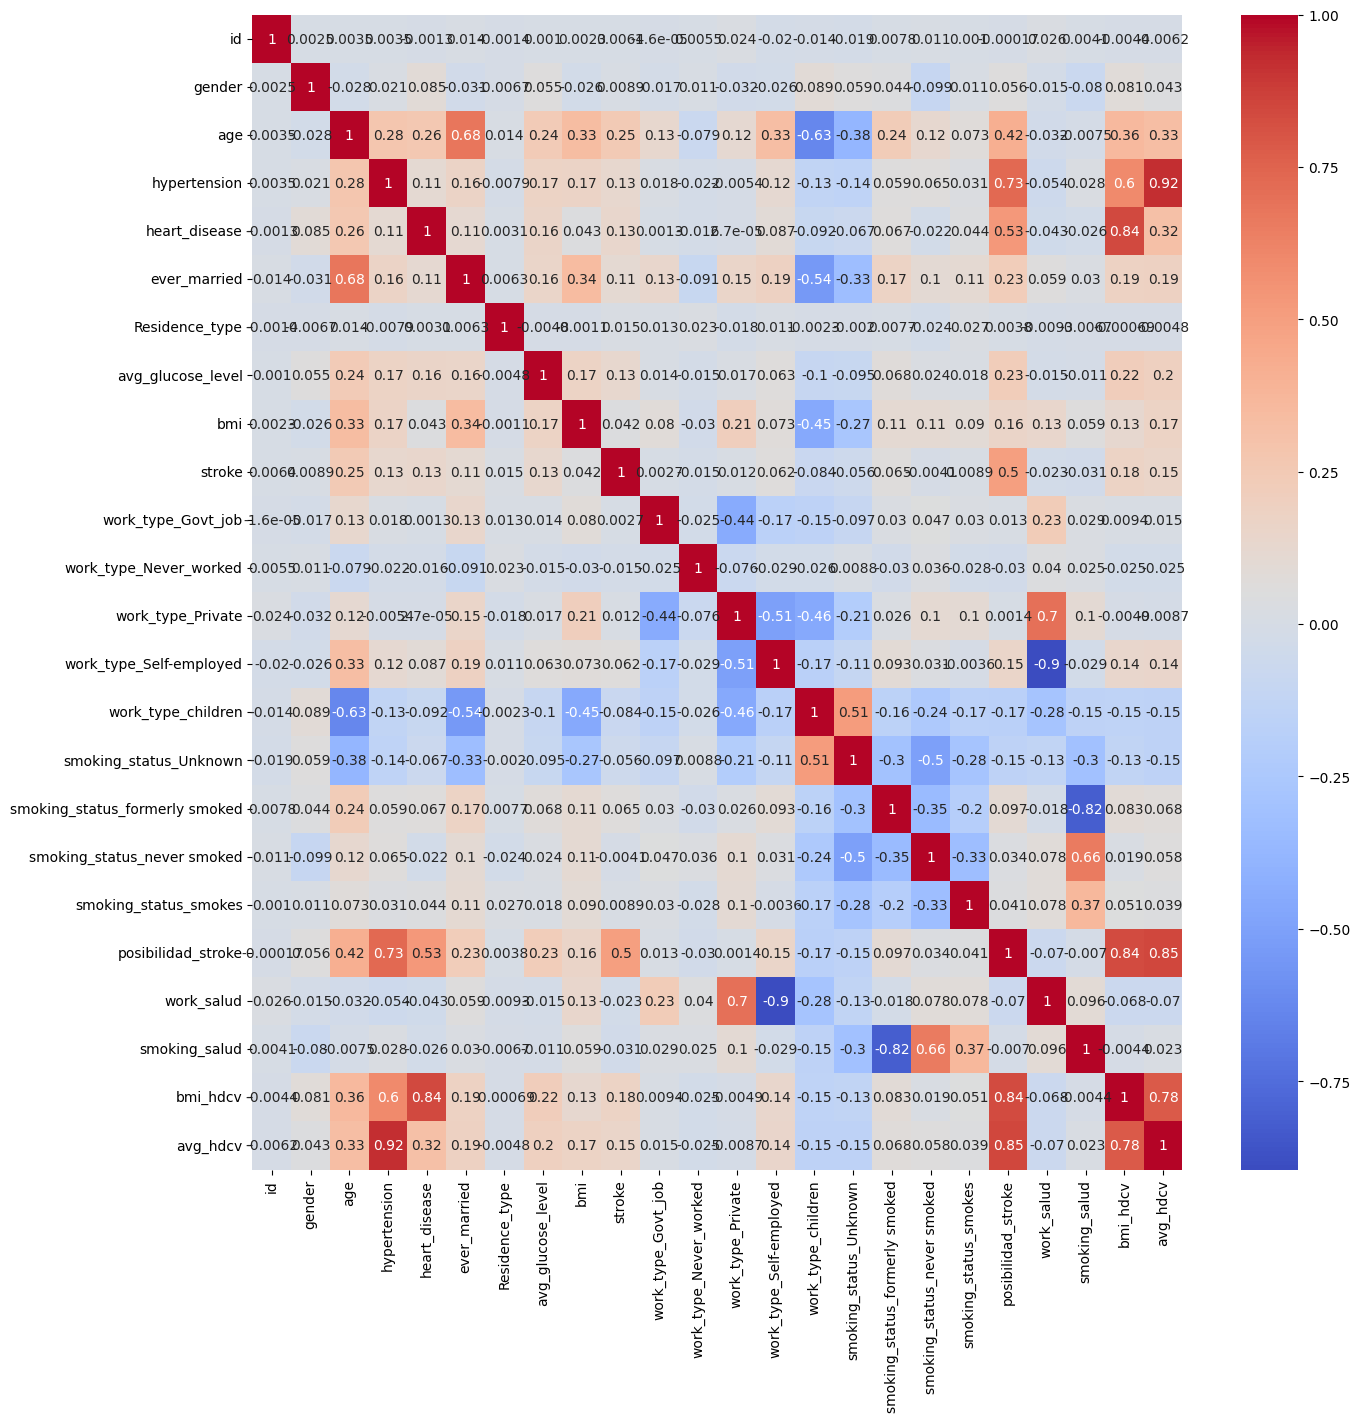

In [19]:
# Calcular la matriz de correlación
corr_matrix = df.corr()

# Graficar la matriz de correlación
plt.figure(figsize=(15, 15))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

Empiezo con la creacion y entrenamiento de distintos modelos para la prediccion de la variable Stroke.
Teniendo en cuenta que mi objetivo es predecir una variable voy a usar modelos de entrenamiento supervisado
Regresion Logistica, KNN y Arbol de Desicion.

El primero un modelo de Regresion Logistica

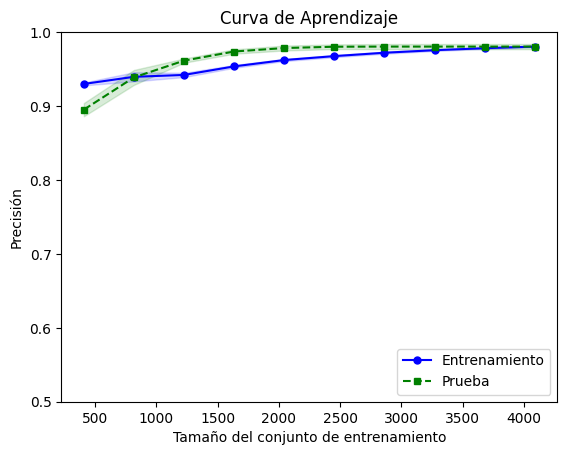

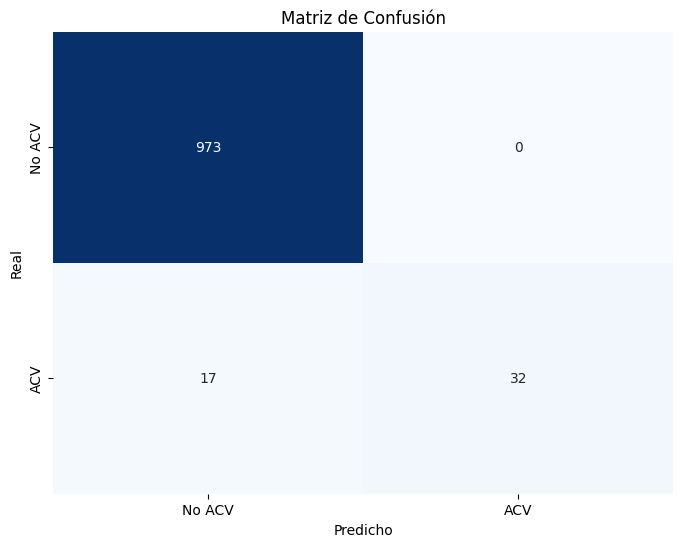

Precisión: 1.00
Recall: 0.65
F1-score: 0.79
AUC-ROC: 0.83


In [30]:
# Seleccionar las características y la variable objetivo
X = df[['gender', 'age', 'avg_glucose_level', 'bmi', 'posibilidad_stroke', 'work_salud', 'smoking_salud', 'bmi_hdcv', 'avg_hdcv']]
y = df['stroke']

# Escalar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dividir df en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=83)

# Crear el modelo de regresión logística con max_iter aumentado
reg = LogisticRegression(max_iter=200)

# Entrenar el modelo con los datos de entrenamiento
reg.fit(X_train, y_train)

# Predecir los valores de stroke para los datos de entrenamiento y prueba
train_pred = reg.predict(X_train)
test_pred = reg.predict(X_test)

# Calcular la precisión para los datos de entrenamiento y prueba
train_acc = accuracy_score(y_train, train_pred)
test_acc = accuracy_score(y_test, test_pred)

# Calcular la curva de aprendizaje
train_sizes, train_scores, test_scores = learning_curve(reg, X_scaled, y, train_sizes=np.linspace(0.1, 1.0, 10), cv=5)

# Calcular las medias y desviaciones estándar de las puntuaciones de entrenamiento y prueba
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Graficar la curva de aprendizaje
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Entrenamiento')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Prueba')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.xlabel('Tamaño del conjunto de entrenamiento')
plt.ylabel('Precisión')
plt.title('Curva de Aprendizaje')
plt.legend(loc='lower right')
plt.ylim([0.5, 1.0])
plt.show()

# Crear la matriz de confusión
confusion = confusion_matrix(y_test, test_pred)

# Crear un heatmap para visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.xticks([0.5, 1.5], ['No ACV', 'ACV'])
plt.yticks([0.5, 1.5], ['No ACV', 'ACV'])
plt.show()

# Calcular métricas de evaluación
accuracy = accuracy_score(y_test, test_pred)
precision = precision_score(y_test, test_pred)
recall = recall_score(y_test, test_pred)
f1 = f1_score(y_test, test_pred)
roc_auc = roc_auc_score(y_test, test_pred)

# Imprimir las métricas
print(f'Precisión: {accuracy:.2f}')
print(f'Precisión: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1:.2f}')
print(f'AUC-ROC: {roc_auc:.2f}')

El segundo un modelo KNN

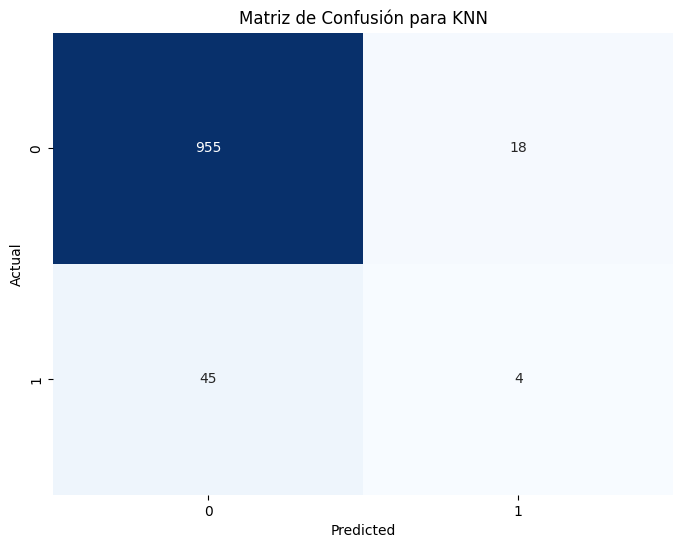

Precisión de KNN en datos de prueba: 0.9383561643835616


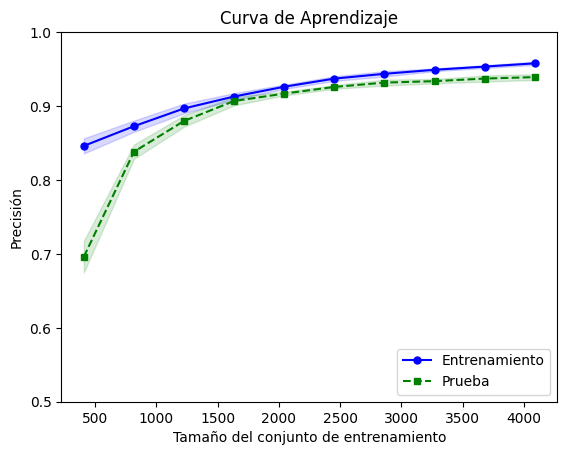

In [21]:
# Crear el modelo KNN
knn_model = KNeighborsClassifier(n_neighbors=3)

# Entrenar el modelo con los datos de entrenamiento
knn_model.fit(X_train, y_train)

# Predecir los valores de stroke para los datos de prueba
knn_test_pred = knn_model.predict(X_test)

# Calcular la precisión para los datos de prueba
knn_test_acc = accuracy_score(y_test, knn_test_pred)
# Crear la matriz de confusión para KNN
cm_knn = confusion_matrix(y_test, knn_test_pred)

# Crear el heatmap de la matriz de confusión para KNN
plt.figure(figsize=(8, 6))
sns.heatmap(cm_knn, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Matriz de Confusión para KNN')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
print("Precisión de KNN en datos de prueba:", knn_test_acc)

# Calcular la curva de aprendizaje
train_sizes, train_scores, test_scores = learning_curve(knn_model, X, y, train_sizes=np.linspace(0.1, 1.0, 10), cv=5)

# Calcular las medias y desviaciones estándar de las puntuaciones de entrenamiento y prueba
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Graficar la curva de aprendizaje
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Entrenamiento')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Prueba')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.xlabel('Tamaño del conjunto de entrenamiento')
plt.ylabel('Precisión')
plt.title('Curva de Aprendizaje')
plt.legend(loc='lower right')
plt.ylim([0.5, 1.0])
plt.show()


El tercero un modelo de un Arbol de Clasificacion

MSE del Árbol de Regresión en datos de prueba: 0.016634050880626222
R² del Árbol de Regresión en datos de prueba: 0.6355894875935986


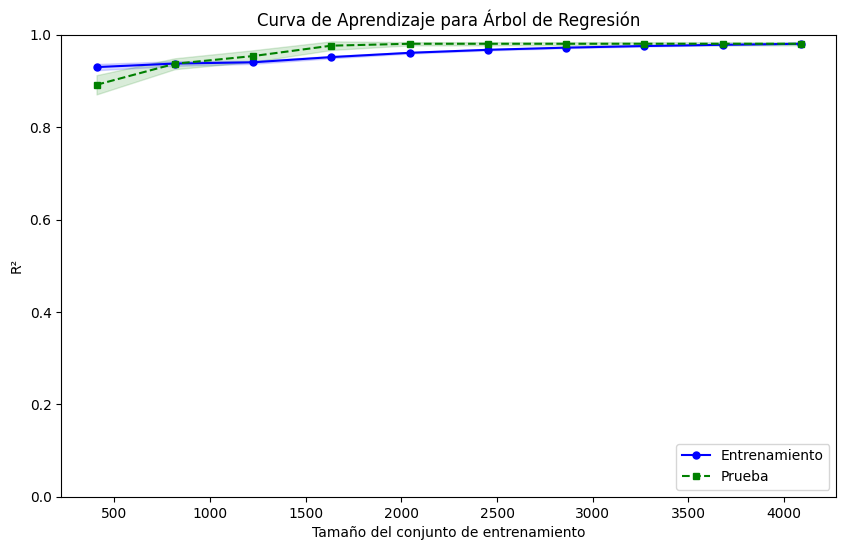

In [37]:
# Crear el modelo de Árbol de Regresión
tree_model = DecisionTreeClassifier (max_depth=3)

# Entrenar el modelo con los datos de entrenamiento
tree_model.fit(X_train, y_train)

# Predecir los valores para los datos de prueba
tree_test_pred = tree_model.predict(X_test)

# Calcular el MSE (Error Cuadrático Medio) para los datos de prueba
tree_mse = mean_squared_error(y_test, tree_test_pred)

# Calcular el coeficiente R²
tree_r2 = r2_score(y_test, tree_test_pred)

# Imprimir los resultados
print("MSE del Árbol de Regresión en datos de prueba:", tree_mse)
print("R² del Árbol de Regresión en datos de prueba:", tree_r2)

# Calcular la curva de aprendizaje
train_sizes, train_scores, test_scores = learning_curve(tree_model, X, y, train_sizes=np.linspace(0.1, 1.0, 10), cv=5)

# Calcular las medias y desviaciones estándar de las puntuaciones de entrenamiento y prueba
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Graficar la curva de aprendizaje
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Entrenamiento')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Prueba')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.xlabel('Tamaño del conjunto de entrenamiento')
plt.ylabel('R²')
plt.title('Curva de Aprendizaje para Árbol de Regresión')
plt.legend(loc='lower right')
plt.ylim([0.0, 1.0])
plt.show()

Hago cross validation a los 3 modelos (Regresion, KNN y Arbol)

In [38]:
# Seleccionar las características y la variable objetivo
X = df[['gender', 'age', 'avg_glucose_level', 'bmi', 'posibilidad_stroke', 'work_salud', 'smoking_salud', 'bmi_hdcv', 'avg_hdcv']]
y = df['stroke']

# Escalar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Definir los modelos
reg = LogisticRegression()
knn_model = KNeighborsClassifier()
tree_model = DecisionTreeClassifier()  # Cambiado a DecisionTreeClassifier

models = [reg, knn_model, tree_model]

# Definir una función para calcular el F1-score
f1_scorer = make_scorer(f1_score)

# Calcular el F1-score promedio para cada modelo utilizando validación cruzada
for model in models:
    scores = cross_val_score(model, X_scaled, y, cv=5, scoring=f1_scorer)
    print(f"F1-score promedio para {model.__class__.__name__}: {scores.mean():.2f} (+/- {scores.std():.2f})")

F1-score promedio para LogisticRegression: 0.75 (+/- 0.05)
F1-score promedio para KNeighborsClassifier: 0.73 (+/- 0.06)
F1-score promedio para DecisionTreeClassifier: 0.68 (+/- 0.03)


F1-score promedio para LogisticRegression: 0.74 (+/- 0.05)

F1-score promedio para KNeighborsClassifier: 0.10 (+/- 0.03)

F1-score promedio para DecisionTreeRegressor: nan (+/- nan)

De los 3 modelos utilizados para predecir stroke el modelo Regresion Logistica es el mejor con 74%, le sigue el KNN con 10% y el Arbol de Decision ultimo con NaN

Optimizo los hiperparametros con Gridsearch

In [41]:
# Seleccionar las características y la variable objetivo para df
X = df[['gender', 'age', 'avg_glucose_level', 'bmi', 'posibilidad_stroke', 'work_salud', 'smoking_salud', 'bmi_hdcv', 'avg_hdcv']]
y = df['stroke']

# Dividir df en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=83)

# Define los hiperparámetros y sus valores posibles para cada modelo
param_grid_reg = {
    'C': [0.1, 1.0, 10.0],
    'penalty': ['l2'],  # Solo usar 'l2'
}
param_grid_knn = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
}

param_grid_tree = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
}

# Crea instancias de GridSearchCV para cada modelo
grid_reg = GridSearchCV(estimator=LogisticRegression(max_iter=1000), param_grid=param_grid_reg, scoring='accuracy', cv=5)
grid_knn = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=param_grid_knn, scoring='accuracy', cv=5)
grid_tree = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=param_grid_tree, scoring='accuracy', cv=5)  # Cambiado a DecisionTreeClassifier

# Ajusta los hiperparámetros para cada modelo
grid_reg.fit(X_train, y_train)
grid_knn.fit(X_train, y_train)
grid_tree.fit(X_train, y_train)

# Imprime los mejores hiperparámetros y las mejores puntuaciones para cada modelo
print("Mejores hiperparámetros para 'reg':", grid_reg.best_params_)
print("Mejor puntuación para 'reg':", grid_reg.best_score_)

print("Mejores hiperparámetros para 'knn_model':", grid_knn.best_params_)
print("Mejor puntuación para 'knn_model':", grid_knn.best_score_)

print("Mejores hiperparámetros para 'tree_model':", grid_tree.best_params_)
print("Mejor puntuación para 'tree_model':", grid_tree.best_score_)


Mejores hiperparámetros para 'reg': {'C': 10.0, 'penalty': 'l2'}
Mejor puntuación para 'reg': 0.9796964264872677
Mejores hiperparámetros para 'knn_model': {'n_neighbors': 7, 'weights': 'uniform'}
Mejor puntuación para 'knn_model': 0.9469174300395327
Mejores hiperparámetros para 'tree_model': {'max_depth': 10, 'min_samples_split': 10}
Mejor puntuación para 'tree_model': 0.9691784900928615


Mejores hiperparámetros para 'reg': {'C': 10.0, 'penalty': 'l2'}

Mejor puntuación para 'reg': 0.9792074289322557

Mejores hiperparámetros para 'knn_model': {'n_neighbors': 7, 'weights': 'uniform'}

Mejor puntuación para 'knn_model': 0.947162527345258

Mejores hiperparámetros para 'tree_model': {'max_depth': None, 'min_samples_split': 2}

Mejor puntuación para 'tree_model': 0.9657507189820231

Utilizo metricas para comparar los modelos

R-cuadrado (R²): 

In [25]:
# Seleccionar las características y la variable objetivo para df
X = df[['gender', 'age', 'avg_glucose_level', 'bmi', 'posibilidad_stroke', 'work_salud', 'smoking_salud', 'bmi_hdcv', 'avg_hdcv']]
y = df['stroke']

# Dividir df en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=83)
y_true = y_test

reg_test_pred = grid_reg.predict(X_test)
knn_test_pred = grid_knn.predict(X_test)
tree_test_pred = grid_tree.predict(X_test)

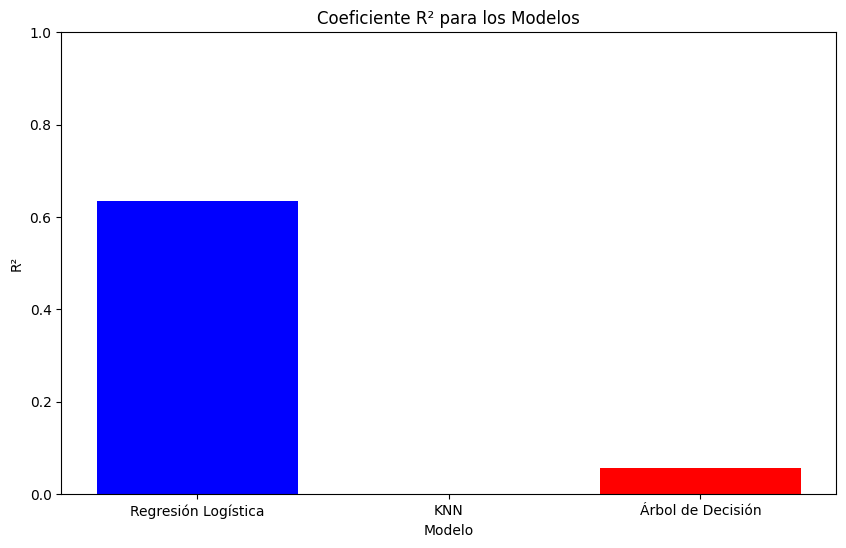

In [26]:
# Calcular el R² para los tres modelos
reg_r2 = r2_score(y_test, reg_test_pred)
knn_r2 = r2_score(y_test, knn_test_pred)
tree_r2 = r2_score(y_test, tree_test_pred)

# Graficar el R² para los tres modelos
model_names = ['Regresión Logística', 'KNN', 'Árbol de Decisión']
r2_scores = [reg_r2, knn_r2, tree_r2]

plt.figure(figsize=(10, 6))
plt.bar(model_names, r2_scores, color=['blue', 'green', 'red'])
plt.xlabel('Modelo')
plt.ylabel('R²')
plt.title('Coeficiente R² para los Modelos')
plt.ylim([0.0, 1.0])
plt.show()


El modelo de Regresion tiene mejor coeficiente R² que el de Arbol pero ambos tienen mejor que el modelo KNN

MAE (Error Absoluto Medio):

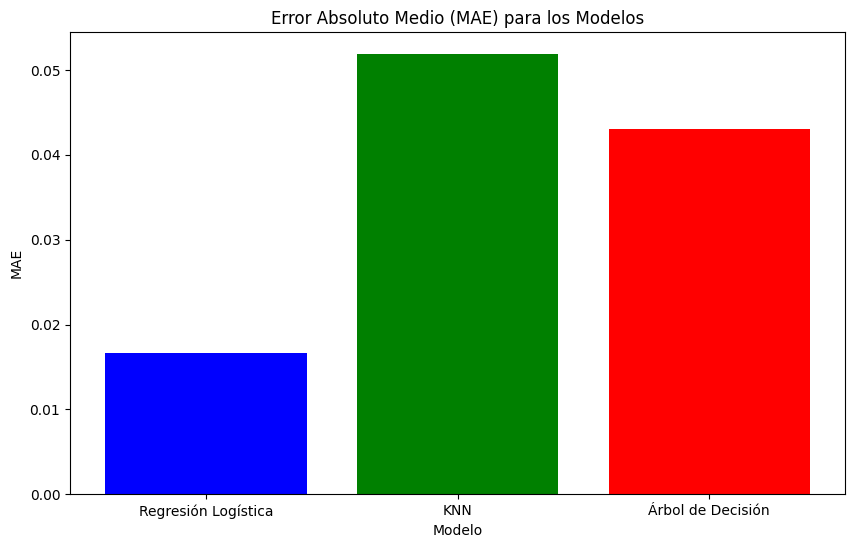

In [27]:
# Calcular el MAE para los tres modelos
reg_mae = mean_absolute_error(y_test, reg_test_pred)
knn_mae = mean_absolute_error(y_test, knn_test_pred)
tree_mae = mean_absolute_error(y_test, tree_test_pred)

# Graficar el MAE para los tres modelos
mae_scores = [reg_mae, knn_mae, tree_mae]

plt.figure(figsize=(10, 6))
plt.bar(model_names, mae_scores, color=['blue', 'green', 'red'])
plt.xlabel('Modelo')
plt.ylabel('MAE')
plt.title('Error Absoluto Medio (MAE) para los Modelos')
plt.show()

El modelo con menor MAE es el de Regresion seguido del Arbol y por ultimo de vuelta el modelo KNN

En conclusion el mejor modelo para predecir un ACV es el de Regresion Logistica, seguido por el de Arbol de Decision y nunca usar KNN.
Pero predecir un ACV es muy dificil de todas formas no solo por las tipo de variables sino que tambien por la falta de pacientes con ACV en el dataset, ya que los ACV son muy poco comunes y se desconoce la razon principal de estos mismos.